In [2]:
import os
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

def printw(*list):
    print(list, end="\n\n")

# Data Preparation

In [3]:
# src = os.getenv("RESOURCE_PATH")+"\\csv\\nbastat2022.csv"
# print(src+"\\csv\\nbastat2022.csv")

data_url = "http://lib.stat.cmu.edu/datasets/boston"

In [4]:
# data = pd.read_csv(src)
# print(len(data))
# print(data.axes)

raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2,:2]])
data = pd.DataFrame(data, columns=['CR1M','ZN','INDUS','CHAS','NOX', 'RM','AGE','DIS','RAD','TAX','RTRATIO','B','LSTAT'])
target = raw_df.values[1::2,2]
target = pd.DataFrame(target, columns=['MDEV'])

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\User\AppData\Local\Temp\ipykernel_13052\3317030092.py:5: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [ ]:
# mat = data[['FG%','3P%','FT%']]
# mat.fillna(0)
# mat = np.array(mat)
# print(mat.shape)

data.head()

In [ ]:
target.head()

### skeleaen 을 이용한 dataset 생성

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

### torch 를 이용한 dataset 생성

In [58]:
data_tensor = torch.tensor(np.array(data), dtype = torch.float32)
target_tensor = torch.tensor(np.array(target), dtype = torch.float32)

dataset = torch.utils.data.TensorDataset(data_tensor, target_tensor)

test_size = 0.2
test_size = int(np.round(test_size*len(dataset)))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_size, test_size]) 

<class 'tuple'>


# Linear Regression

In [48]:
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_size = input_size // 2
        self.Layer = nn.Sequential(nn.Linear(input_size, self.hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(self.hidden_size, 1))
        
    def forward(self, x):
        return self.Layer(x)
    
model = RegressionModel(13)

In [49]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### train for each sample

In [41]:
for epoch in tqdm(range(100)):
    for (x,y) in train_dataset:
        optimizer.zero_grad()

        y_pred = model(x)

        loss = loss_fn(y_pred, y)

        loss.backward()

        optimizer.step()

100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


### Batch training version

In [43]:
batch_size =10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in tqdm(range(100)):
    for (x,y) in train_loader:
        optimizer.zero_grad()

        y_pred = model(x)

        loss = loss_fn(y_pred, y)

        loss.backward()

        optimizer.step()

100%|██████████| 100/100 [00:01<00:00, 59.38it/s]


### using GPU

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# train_dataset.tensors = [tensor.to(device) for tensor in train_dataset.dataset.tensors]
# test_dataset.tensors = [tensor.to(device) for tensor in test_dataset.dataset.tensors]

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in tqdm(range(100)):
    for (x,y) in train_loader:
        optimizer.zero_grad()

        y_pred = model(x.to(device))

        loss = loss_fn(y_pred, y.to(device))

        loss.backward()

        optimizer.step()

100%|██████████| 100/100 [00:03<00:00, 28.70it/s]


In [66]:
with torch.no_grad(): #model.eval()
    y_pred = []
    nn_y_test = []
    for (x,y) in test_dataset:
        temp_y = model(x.to(device)).detach().cpu().numpy()
        y_pred.append(temp_y)
        nn_y_test.append(y)

    print(np.sqrt(mean_squared_error(y_pred, nn_y_test)))

4.7772017


# Logistic Regression

### Data preparation

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/titanic_train.csv")

df = df.dropna()

X = df[['Pclass', "Sex", "Age", "Fare"]]
y = df["Survived"]

X = pd.get_dummies(X, columns=["Sex"], dtype='int').values
y = y.values
#y = pd.get_dummies(y, columns=["Survived"], dtype='int').values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(y_test.shape)

(37,)


In [6]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [7]:
#Dataset class 를 상속하면 아래 메소드들은 반드시 정의해야 함
class TitanicDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.long)

    def __getitem__(self, index): #index 에 해당하는 데이터 반환
        return self.x_data[index], self.y_data[index]
    
    def __len__(self): #데이터의 길이 반환
        return self.x_data.shape[0]
    
dataset = TitanicDataset(X_train, y_train)

In [8]:
class MyLogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.Layer = nn.Sequential(nn.Linear(5,1),
                                   nn.Sigmoid(),
                                   )
        
    def forward(self, x):
        return self.Layer(x)
        
model = MyLogisticRegression()

In [9]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [10]:
losses = []

for epoch in tqdm(range(100)):
    for i, (x,y) in enumerate(dataloader):
        optimizer.zero_grad()

        y_pred = model(x)
        loss = loss_fn(y_pred, y.type(torch.float32).view(-1,1))

        loss.backward()
        optimizer.step()

        losses.append(loss.detach().numpy())

        # if i % 10 == 0:
        #     print(f"Epoch: {epoch + 1}, Batch: {i}, Loss: {loss.item():.4f}")

100%|██████████| 100/100 [00:00<00:00, 195.31it/s]


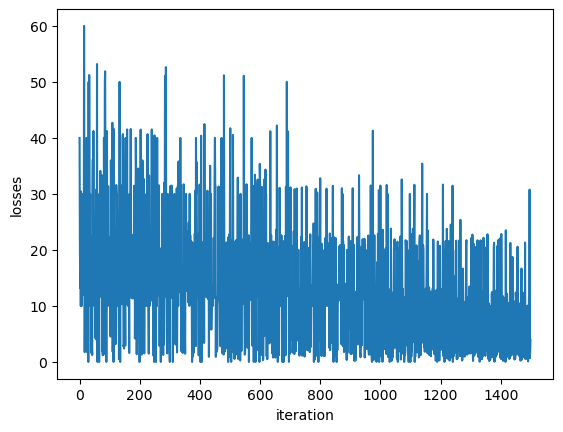

In [11]:
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("losses")
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

y_pred = lr_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred, y_test))
print("Precision: ", precision_score(y_pred, y_test))
print("recall: ", recall_score(y_pred, y_test))
printw("f1 score: ", f1_score(y_pred, y_test))
print(classification_report(y_pred, y_test))

Accuracy:  0.6216216216216216
Precision:  0.8421052631578947
recall:  0.5925925925925926
('f1 score: ', 0.6956521739130435)

              precision    recall  f1-score   support

           0       0.39      0.70      0.50        10
           1       0.84      0.59      0.70        27

    accuracy                           0.62        37
   macro avg       0.62      0.65      0.60        37
weighted avg       0.72      0.62      0.64        37



In [15]:
nn_y_pred = []

with torch.no_grad(): #model.eval()
    for x, y in zip(X_test, y_test):
        outputs = model(torch.tensor([x], dtype=torch.float32))
        predicted = torch.argmax(outputs.data, 1)
        predicted = 1 - predicted
        nn_y_pred.append(predicted.detach().cpu().item())

print("Accuracy: ", accuracy_score(nn_y_pred, y_test))
print("Precision: ", precision_score(nn_y_pred, y_test))
print("recall: ", recall_score(nn_y_pred, y_test))
printw("f1 score: ", f1_score(nn_y_pred, y_test))
print(classification_report(nn_y_pred, y_test))

Accuracy:  0.5135135135135135
Precision:  1.0
recall:  0.5135135135135135
('f1 score: ', 0.6785714285714285)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.51      0.68        37

    accuracy                           0.51        37
   macro avg       0.50      0.26      0.34        37
weighted avg       1.00      0.51      0.68        37



c:\Users\User\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
